,region,year,coverage,area_type
0,World,2021,61.7,Total
1,Low-income,2021,20.9,Total
2,Lower-middle-income,2021,46.6,Total
3,Upper-middle-income,2021,74.1,Total
4,High-income,2021,90.0,Total


,year,coverage
count,168.000000,168.000000
mean,2022.500000,63.667857
std,1.121376,30.841286
min,2021.000000,12.500000
25%,2021.750000,44.025000
50%,2022.500000,65.600000
75%,2023.250000,83.225000
max,2024.000000,323.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   region     168 non-null    object 
 1   year       168 non-null    int64  
 2   coverage   168 non-null    float64
 3   area_type  168 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.4+ KB


region       0
year         0
coverage     0
area_type    0
dtype: int64

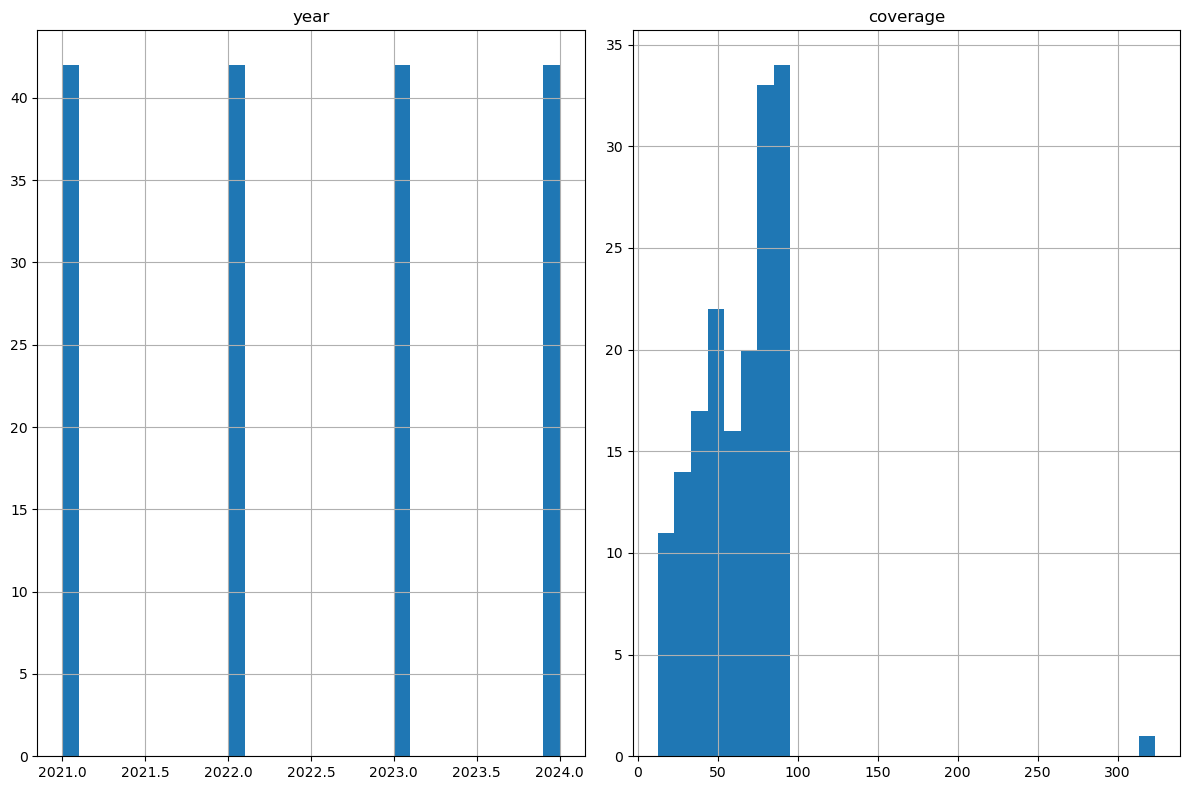

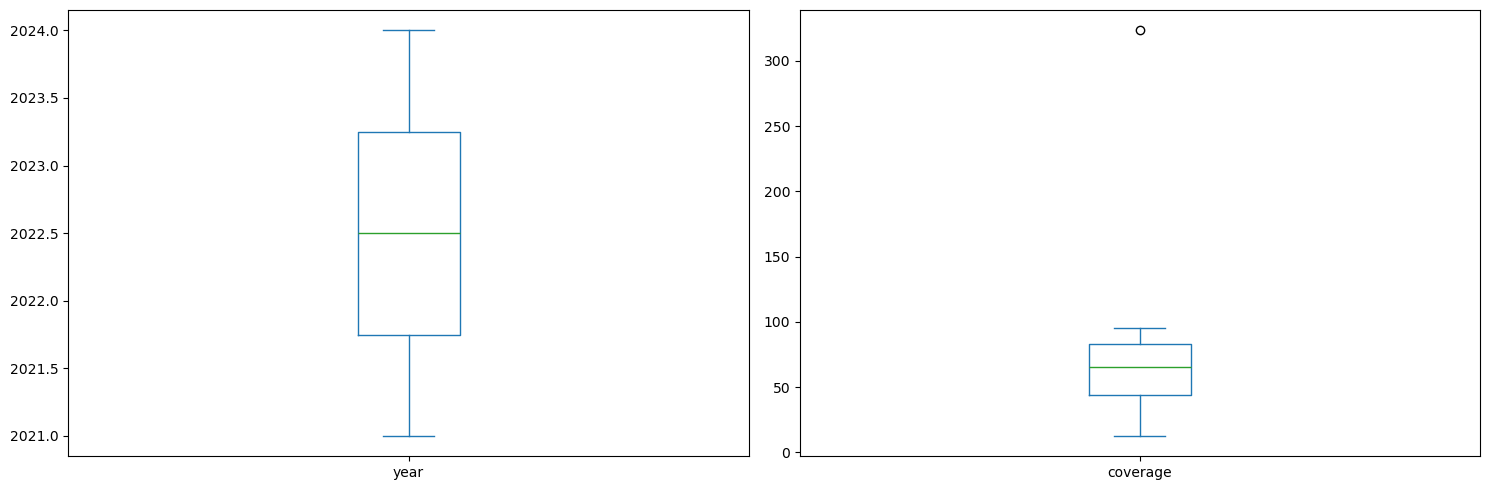

ValueError: could not convert string to float: 'World'

<Figure size 1000x800 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Recharger le CSV après reset
df = pd.read_csv('/mnt/data/coverage_urban_rural_total_long.csv')

# Aperçu
print("Aperçu des premières lignes :")
print(df.head(), "\n")

print("Informations générales :")
df.info()
print()

print("Statistiques descriptives :")
print(df.describe(), "\n")

print("Valeurs manquantes par colonne :")
print(df.isna().sum(), "\n")

# Histogramme de la distribution de 'coverage'
plt.figure()
df['coverage'].hist()
plt.title('Distribution de la couverture (%)')
plt.xlabel('Couverture (%)')
plt.ylabel('Nombre d\'observations')
plt.show()

# Boxplot de 'coverage' par 'area_type'
plt.figure()
df.boxplot(column='coverage', by='area_type')
plt.title('Couverture (%) par type de zone')
plt.suptitle('')
plt.xlabel('Type de zone')
plt.ylabel('Couverture (%)')
plt.show()

# Heatmap des corrélations entre coverage des différentes années
pivot = df.pivot_table(index=['region', 'area_type'], columns='year', values='coverage')
corr = pivot.corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr)
plt.title('Matrice de corrélation des années (coverage)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(label='Corrélation')
plt.tight_layout()
plt.show()
